In [301]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sbaghbidi/human-faces-object-detection")

# print("Path to dataset files:", path)

In [302]:
import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2


In [303]:
# Load the CSV file
bbox_data = pd.read_csv('data/faces.csv')

# Get the unique image names - since each image may have multiple bounding boxes, we need to get the unique image names
image_names = bbox_data['image_name'].unique()

# Split the data into training and testing sets
train_images, test_images = train_test_split(image_names, test_size=0.2, random_state=42)

# Create DataFrames for training and testing
train_df = bbox_data[bbox_data['image_name'].isin(train_images)]
test_df = bbox_data[bbox_data['image_name'].isin(test_images)]

print("Training samples:", len(train_df), "Testing samples:", len(test_df))


Training samples: 2686 Testing samples: 664


In [304]:
class FacesDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
        # Get list of unique image names
        self.image_names = self.dataframe['image_name'].unique()
        
        # Group bounding boxes by image name
        self.groups = self.dataframe.groupby('image_name')
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        
        # Get bounding boxes
        records = self.groups.get_group(image_name)
        boxes = records[['x0', 'y0', 'x1', 'y1']].values
        
        # Apply transformations
        sample = {
            'image': image,
            'bboxes': boxes,
            'labels': [0] * len(boxes)  # Dummy labels for albumentations lib
        }
        
        if self.transform:
            sample = self.transform(**sample)
        
        # Convert to tensors
        image = sample['image']
        boxes = torch.tensor(sample['bboxes'])
        
        return image, boxes


In [305]:
# Random Affine Transformations
transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(512, 512),
    A.HorizontalFlip(p=0.4),
    #A.ShiftScaleRotate(p=0.8),
    A.ColorJitter(p=0.42),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomScale(scale_limit=0.1, p=0.3),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])) # to take care of the boudning boxes


In [306]:
train_dataset = FacesDataset(train_df, image_dir='data/images', transform=transform)
test_dataset = FacesDataset(test_df, image_dir='data/images', transform=transform)

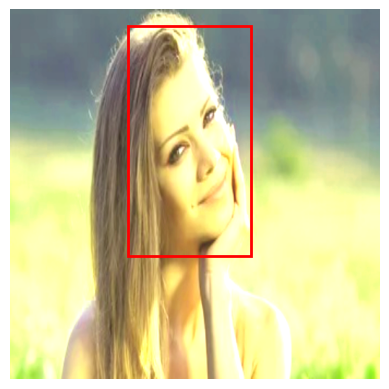

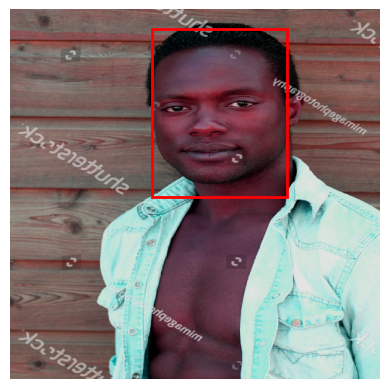

In [307]:
def display_image_with_bboxes(image, bboxes):
    # Convert tensor image to NumPy array
    image = image.permute(1, 2, 0).cpu().numpy()

    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Plot bounding boxes
    for bbox in bboxes:
        x0, y0, x1, y1 = bbox
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# Visualize two samples to ensure random and consistent augmentations
for _ in range(2):
    idx = random.randint(0, len(train_dataset) - 1)
    image, bboxes = train_dataset[idx]
    display_image_with_bboxes(image, bboxes)


# Section 1.2

In [313]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import ResNet50_Weights

# Load pre-trained ResNet-50 model using the updated 'weights' parameter
backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze backbone weights
for param in backbone.parameters():
    param.requires_grad = False


In [309]:
class ObjectDetectionModel(nn.Module):
    def __init__(self, backbone):
        super(ObjectDetectionModel, self).__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # Remove the original classification head
        self.regressor = nn.Linear(2048, 4)  # New regression head for bounding boxes
        
    def forward(self, x):
        features = self.backbone(x)
        bbox_preds = self.regressor(features)
        return bbox_preds

# Instantiate the model
model = ObjectDetectionModel(backbone)


In [310]:
num_workers = 0  
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=True)

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()  # Also known as Huber loss
optimizer = torch.optim.Adam(model.regressor.parameters(), lr=1e-3)

# Determine the device - because I am thinking of either running on my mac or the cloud nodes

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

# Integrate mixed precision training if using CUDA
use_amp = torch.cuda.is_available()

if use_amp:
    scaler = torch.cuda.amp.GradScaler()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in progress_bar:
        images = images.to(device)
        targets = targets.to(device)  # Shape: [batch_size, 4]

        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(images)  # Shape: [batch_size, 4]
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


In [ ]:
def compute_iou(box1, box2):
    xA = torch.max(box1[:, 0], box2[:, 0])
    yA = torch.max(box1[:, 1], box2[:, 1])
    xB = torch.min(box1[:, 2], box2[:, 2])
    yB = torch.min(box1[:, 3], box2[:, 3])
    
    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)
    
    box1Area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2Area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    
    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    
    return iou

model.eval()
with torch.no_grad():
    total_iou = 0
    count = 0
    for images, targets in test_loader:
        images = torch.stack(images).to(device)
        targets = torch.stack([t[0] for t in targets]).to(device)
        outputs = model(images)
        
        ious = compute_iou(outputs, targets)
        total_iou += ious.sum().item()
        count += len(ious)
    
    mean_iou = total_iou / count
    print(f"Mean IoU on test set: {mean_iou:.4f}")
